In [1]:
import yfinance as yf
import pandas as pd
apple = yf.Ticker("AAPL")
apple = apple.history(period="max")
del apple["Dividends"]
del apple["Stock Splits"]
apple["Tomorrow"] = apple["Close"].shift(-1)
apple["Target"] = (apple["Tomorrow"] > apple["Close"]).astype(int)
apple = apple.loc["1990-01-01":].copy()

In [2]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = apple.iloc[:-100]
test = apple.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [3]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.39285714285714285

<Axes: xlabel='Date'>

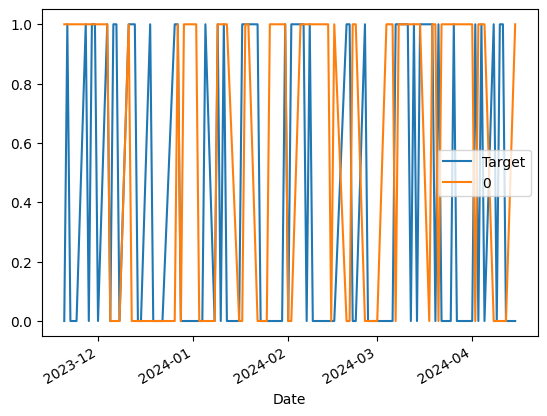

In [4]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [5]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [6]:
predictions = backtest(apple, model, predictors)
predictions["Predictions"].value_counts()

Predictions
0    4193
1    1944
Name: count, dtype: int64

In [7]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5128600823045267

In [8]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.520287
0    0.479713
Name: count, dtype: float64

In [11]:
file_path = '~/Documents/CS 5100/Stock-Trends/data/news/sentiments/general_scores.csv'
df = pd.read_csv(file_path)
del df['Avg_Polarity']
del df['Avg_Subjectivity']
df

,Date,Avg_Pos_Score,Avg_Neu_Score,Avg_Neg_Score
0,2019-01-01,0.038333,0.894889,0.066778
1,2019-01-02,0.073750,0.848000,0.078250
2,2019-01-03,0.057667,0.906111,0.036222
3,2019-01-04,0.069222,0.833000,0.097889
4,2019-01-07,0.056111,0.815444,0.128556
...,...,...,...,...
518,2020-12-25,0.049800,0.882600,0.067600
519,2020-12-28,0.096300,0.814900,0.088800
520,2020-12-29,0.094500,0.828800,0.076700
521,2020-12-30,0.112500,0.844700,0.042600


In [22]:
apple_copy = apple.copy()
apple_copy.reset_index(inplace=True)
apple_copy['Date'] = apple_copy['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
merged_data = pd.merge(apple_copy, df, on='Date', how='outer')
merged_data.set_index('Date', inplace=True)
merged_data = merged_data.dropna()
tomorrow = merged_data.pop('Tomorrow')
merged_data['Tomorrow'] = tomorrow
del merged_data['Target']
merged_data

,Open,High,Low,Close,Volume,Avg_Pos_Score,Avg_Neu_Score,Avg_Neg_Score,Tomorrow
Date,,,,,,,,,
2019-01-02,37.118910,38.067913,36.960742,37.845039,148158800.0,0.073750,0.848000,0.078250,34.075397
2019-01-03,34.504364,34.921351,34.029864,34.075397,365248800.0,0.057667,0.906111,0.036222,35.530048
2019-01-04,34.636166,35.599548,34.461225,35.530048,234428400.0,0.069222,0.833000,0.097889,35.450958
2019-01-07,35.635487,35.666643,34.964475,35.450958,219111200.0,0.056111,0.815444,0.128556,36.126778
2019-01-08,35.841597,36.383202,35.592366,36.126778,164101200.0,0.040000,0.874100,0.085900,36.740265
...,...,...,...,...,...,...,...,...,...
2020-12-24,128.876581,130.976762,128.660673,129.514481,54930100.0,0.086500,0.804400,0.109100,134.146637
2020-12-28,131.496878,134.784537,131.025799,134.146637,124486200.0,0.096300,0.814900,0.088800,132.360489
2020-12-29,135.481327,136.207548,131.840352,132.360489,121047300.0,0.094500,0.828800,0.076700,131.231918


In [29]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Assuming 'merged_data' is your dataframe containing the stock data
data_tensor = torch.tensor(merged_data.values, dtype=torch.float32)

# Split the data into input features (X) and target variable (y)
X = data_tensor[:, :5]  # Open, High, low, Close, Volume columns
y = data_tensor[:, -1]   # Last column (Target)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the data into PyTorch datasets and dataloaders
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use only the last output of the sequence
        return out

# Define hyperparameters
input_size = X.shape[1]
hidden_size = 2048
num_layers = 3
output_size = 1

# Instantiate the model
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model (same training loop as before)
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(1))  # Add a dummy sequence length dimension
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

    # Evaluate the model on the validation set (same evaluation as before)
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for inputs, labels in val_dataloader:
            outputs = model(inputs.unsqueeze(1))
            val_loss += criterion(outputs.squeeze(), labels).item()

        val_loss /= len(val_dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss}")

Epoch 1/10, Validation Loss: 3610.9703369140625
Epoch 2/10, Validation Loss: 2506.328125
Epoch 3/10, Validation Loss: 1759.8442993164062
Epoch 4/10, Validation Loss: 1286.7327270507812
Epoch 5/10, Validation Loss: 1034.6982421875
Epoch 6/10, Validation Loss: 931.1074829101562
Epoch 7/10, Validation Loss: 898.6558227539062
Epoch 8/10, Validation Loss: 890.9599304199219
Epoch 9/10, Validation Loss: 889.69189453125
Epoch 10/10, Validation Loss: 892.311767578125


In [30]:
# Assuming 'merged_data' is your dataframe containing the stock data
data_tensor = torch.tensor(merged_data.values, dtype=torch.float32)

# Split the data into input features (X) and target variable (y)
X = data_tensor[:, :-1]  # ALL columns except last
y = data_tensor[:, -1]   # Last column (Target)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the data into PyTorch datasets and dataloaders
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use only the last output of the sequence
        return out

# Define hyperparameters
input_size = X.shape[1]
hidden_size = 2048
num_layers = 3
output_size = 1

# Instantiate the model
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model (same training loop as before)
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(1))  # Add a dummy sequence length dimension
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

    # Evaluate the model on the validation set (same evaluation as before)
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for inputs, labels in val_dataloader:
            outputs = model(inputs.unsqueeze(1))
            val_loss += criterion(outputs.squeeze(), labels).item()

        val_loss /= len(val_dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss}")

Epoch 1/10, Validation Loss: 3544.945068359375
Epoch 2/10, Validation Loss: 2457.520263671875
Epoch 3/10, Validation Loss: 1722.22509765625
Epoch 4/10, Validation Loss: 1256.994140625
Epoch 5/10, Validation Loss: 1025.8269348144531
Epoch 6/10, Validation Loss: 925.2349853515625
Epoch 7/10, Validation Loss: 894.3422546386719
Epoch 8/10, Validation Loss: 888.14208984375
Epoch 9/10, Validation Loss: 887.1686706542969
Epoch 10/10, Validation Loss: 888.890380859375
